# Behaviorial Cloning Project

## Project Writeup
#### Author: Salman Ali Shaukat.
The steps of this project are the following:

#### 1. Import all the stuff which is needed for this project.
#### 2. Gather Data.
#### 3. Pre-process Data for achiving Guassian Distribution.
     a. Import the BIG combined CSV file in matlab
     b. Remove absolute steering values less than 0.0001 and greater than 0.8
     c. Copy the images, based on the selected steering values
     d. Generate a new CSV file for python code
#### 4. Importing & Visulization of the Processed data.

#### 5. Get all the helper function in one place.
     a. Preprocess
     b. get_augmented_row
     c. generator
#### 6. Generation of Train and Validation Set .
#### 7. Finally, the Model.
#### 8. Behold! Model Training in progress.
#### 9. At Last...! Save Model and Visulize MSE.
#### 10. Don't forget to add Image preprocessing in the drive file!

### 1. Import all the stuff which is needed for this project.

In [1]:
# for reading csv file
import csv
# for image processing
import cv2
import pandas as pd  # data analysis toolkit - create, read, update, delete datasets
import numpy as np  # matrix math
from sklearn.model_selection import train_test_split  # to split out training and testing data
# keras is a high level wrapper on top of tensorflow (machine learning library)
# The Sequential container is a linear stack of layers
from keras.models import Sequential
# popular optimization strategy that uses gradient descent
from keras.optimizers import Adam
# to save our model periodically as checkpoints for loading later
from keras.callbacks import ModelCheckpoint
# what types of layers do we want our model to have?
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.layers import Cropping2D
# for reading files
import os
from sklearn.utils import shuffle
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### 2. Gather Data.
The Gathered data includes:
    a. Udacity provided data
    b. Five Laps of forward moving including recovery laps, side to middle lane moves
    c. Five Laps of backward moving including recovery laps, side to middle lane moves
    d. Ten Laps of middle lave moving
        

In [2]:
def getdata(samples):
    angles = []
    for sample in samples:
        angle = float(sample[3])
        angles.append(angle)
    y_train = np.array(angles)
    return y_train

### As you can see that the data points near zero steering values outnumber all of the other data samples.
    So we need to do some processing on this combined data set.

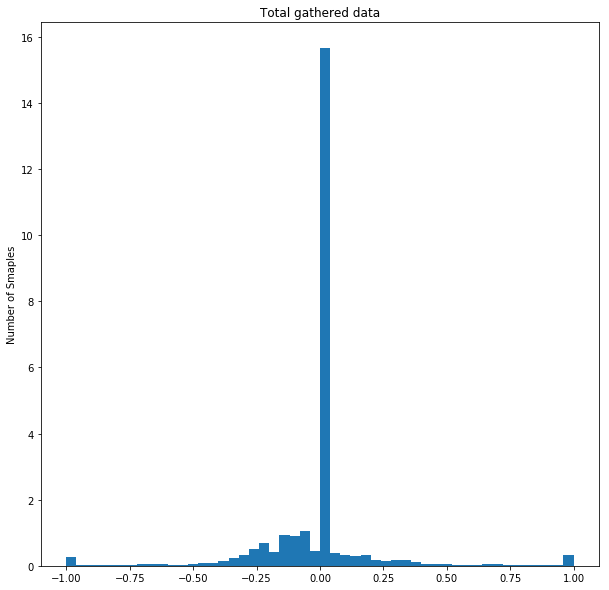

In [3]:
samples = []
with open("driving_log5u12.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
alldata=getdata(samples)
plt.figure(figsize=(10,10))
plt.hist(alldata, normed=True, bins=50)
plt.ylabel('Number of Smaples');
plt.title('Total gathered data');

#### 3. Pre-process Data for achiving Guassian Distribution.
     a. Import the BIG combined CSV file in MatLab
     b. Remove absolute steering values less than 0.0001 and greater than 0.8
         index = find((abs(steering)<0.8)& (abs(steering)>0.0001));
     c. Copy the images & other data, based on the selected steering values
         center = center(index);
         left = left(index);
         right = right(index);
         brake = brake(index);
         steering = steering(index);
         throttle = throttle(index);
         speed = speed(index);
     d. Generate a new CSV file for python code
    

#### 4. Importing & Visulization of the Processed data.

In [4]:
samples = []
with open("final.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
process_data = getdata(samples)
flipped_process_data = process_data * -1

right_shift_data = process_data + .2
flipped_right_shift_data = right_shift_data * -1

left_shift_data = process_data - .2
flipped_left_shift_data = left_shift_data * -1

final_data = np.concatenate((process_data, flipped_process_data, right_shift_data, flipped_right_shift_data,
                             left_shift_data, flipped_left_shift_data), axis=0)

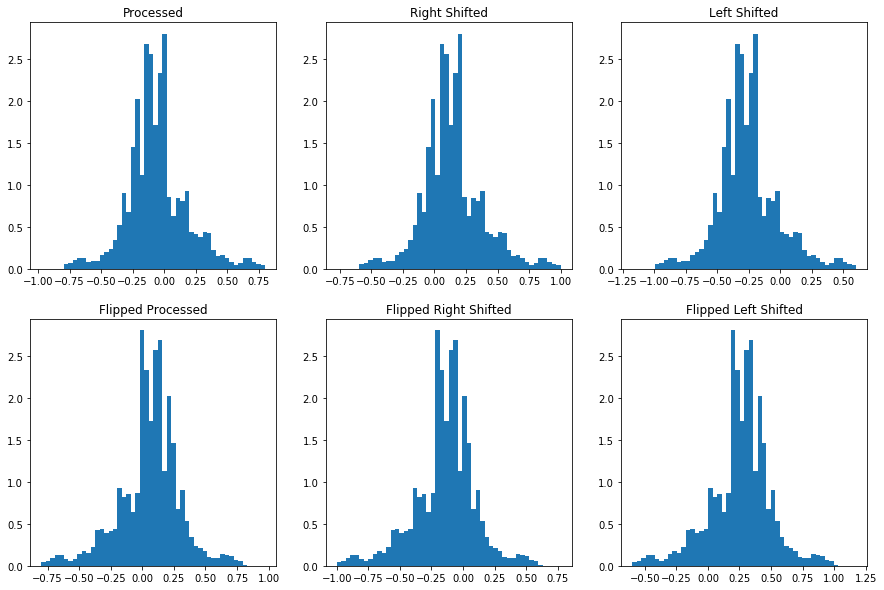

In [5]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 3,figsize=(15,10))
axarr[0, 0].hist(process_data, normed=True, bins=50)
axarr[0, 0].set_title('Processed')
axarr[0, 1].hist(right_shift_data, normed=True, bins=50)
axarr[0, 1].set_title('Right Shifted')
axarr[1, 0].hist(flipped_process_data, normed=True, bins=50)
axarr[1, 0].set_title('Flipped Processed')
axarr[1, 1].hist(flipped_right_shift_data, normed=True, bins=50)
axarr[1, 1].set_title('Flipped Right Shifted')
axarr[0, 2].hist(left_shift_data, normed=True, bins=50)
axarr[0, 2].set_title('Left Shifted')
axarr[1, 2].hist(flipped_left_shift_data, normed=True, bins=50)
axarr[1, 2].set_title('Flipped Left Shifted')


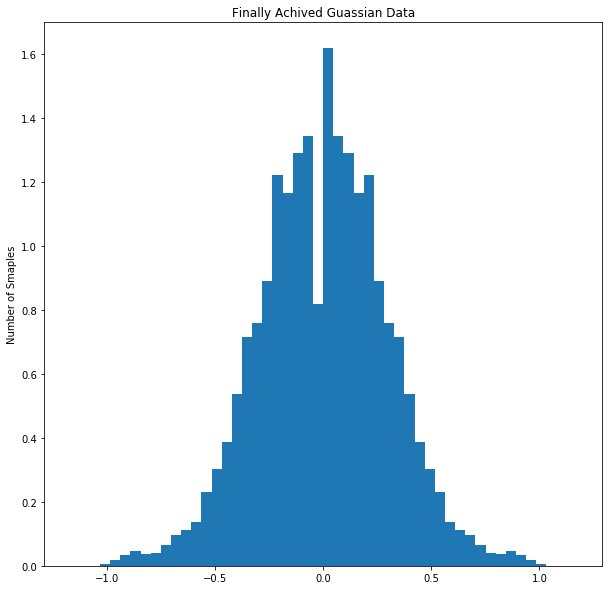

In [6]:
plt.figure(figsize=(10,10))
plt.hist(final_data, normed=True, bins=50)
plt.ylabel('Number of Smaples');
plt.title('Finally Achived Guassian Data');

### 5. Get all the helper function in one place.
     a. preprocess(image):
    This includes the image croping then applying opencv functions of blurring, resizing YUV transformation and finally image normalization. 

     b. get_augmented_row(batch_sample):  
    This finction just randomly chooses Left, Right or Center camera and the applies image preprocessing function and then again randomly decides weather to flip the values or nor.
    
     c. generator(samples, batch_size=128):    
    This function helps to manage the data usage for Large dataset.

In [7]:
# for debugging, allows for reproducible (deterministic) results
np.random.seed(0)
# Global Constants
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3
TARGET_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

In [8]:
def preprocess(image):
    image = image[70:-25,:,:]
    image = cv2.GaussianBlur(image, (3,3),0)
    image = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Convert image from RGB to YUV
    image = image/127.5 - 1.
    return image

def get_augmented_row(batch_sample):
    steering = float(batch_sample[3])
    # randomly choose the camera to take the image from
    camera = int(np.random.choice(['0', '1', '2']))
    # adjust the steering angle for left anf right cameras
    if camera == '2':
        steering += 0.25
    elif camera == '1':
        steering -= 0.25

    name = './IMG/'+batch_sample[camera].split('/')[-1]
    image = preprocess(cv2.imread(name))
    # decide whether to horizontally flip the image:
    # This is done to reduce the bias for turning left that is present in the training data
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        # flip the image and reverse the steering angle
        steering = -1*steering
        image = cv2.flip(image, 1)

    return image, steering

def generator(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                image, angle = get_augmented_row(batch_sample)
                images.append(image)
                angles.append(angle)
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

#### 6. Generation of Train and Validation Set .
    In this part the train validation split is decided to be 80-20. The batch size for the generator is decided to be 128.

In [9]:
samples = []
with open("final.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)            

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [10]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

#### 7. Finally, the Model.

In [11]:
"""
NVIDIA model used
"""
model = Sequential()
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2), input_shape=INPUT_SHAPE))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))  # keep_prob
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))


#### 8. Behold! Model Training in progress.

In [12]:
"""
Train the model
"""
model.summary()
model.compile(loss='mse', optimizer='adam')
hist = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=20)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 30, 30, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 13, 13, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 5, 48)      43248       convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 3, 3, 64)      27712       convolution2d_3[0][0]            
___________________________________________________________________________________________

#### 9. At Last...! Save Model and Visulize MSE.

In [13]:
model.save("model_final.h5")
print("The model is saved")

The model is saved


dict_keys(['loss', 'val_loss'])


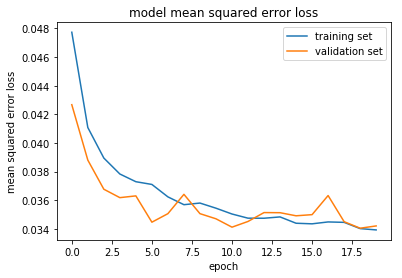

In [14]:
### print the keys contained in the history object
print(hist.history.keys())

### plot the training and validation loss for each epoch
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

#### 10. Don't forget to add Image preprocessing in the drive file!
    For Image preprocessing just use the following function.
    preprocess(image)